In [65]:
# Dependencies and setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import datetime

In [66]:
traffic_raw = []
#Set up the api url and parameters


In [67]:
#while looper == "True":
r = requests.get("https://data.austintexas.gov/resource/dx9v-zd7x.json", params = {
                "$limit": 300000,
                "$offset": 0
                })
if r.status_code == 200:     
        traffic_raw = r.json()
        #print("Record Start = " + str(offset) + "Pagination is " + str(increment))
        #offset += increment
        
else:
    print("***** IT IS BROKEN *****")
    print(r.status_code)

In [68]:
pd.DataFrame(traffic_raw)

,traffic_report_id,published_date,issue_reported,location,latitude,longitude,address,traffic_report_status,traffic_report_status_date_time
0,EBF5283D22437BB974F4248BA0EC4E90F26D32CB_15201...,2018-03-04T08:36:00.000Z,LOOSE LIVESTOCK,"(30.256997,-97.611818)",30.256997,-97.611818,N Fm 973 Rd & Fm 969 Rd,ARCHIVED,1970-01-18T14:16:00.000Z
1,9AE17B153A32567D1646CAA8C4010174C30AC349_15088...,2017-10-24T15:48:00.000Z,Crash Urgent,"(30.415159,-97.688372)",30.415159,-97.688372,12700 Metric Blvd,ARCHIVED,2017-10-24T15:51:00.000Z
2,A6990ED96E2C5ACAC92ACDCC3F83BA4E2893AD76_15088...,2017-10-24T15:49:00.000Z,Traffic Hazard,"(30.224758,-97.766467)",30.224758,-97.766467,300 W Ben White Blvd Wb,ARCHIVED,2017-10-24T15:51:00.000Z
3,551220DEEB362077F5DF356BDEBAF94F34F93F0C_15088...,2017-10-24T15:49:00.000Z,Crash Urgent,"(30.275603,-97.734873)",30.275603,-97.734873,E 15th St & Red River St,ARCHIVED,2017-10-24T15:51:00.000Z
4,0200320AE3BC247E747EF93E3259BC29DDF53392_15088...,2017-10-24T15:48:00.000Z,Crash Urgent,"(30.288241,-97.741506)",30.288241,-97.741506,2414 Guadalupe St,ARCHIVED,2017-10-24T15:51:00.000Z
...,...,...,...,...,...,...,...,...,...
157773,CE7DD1F443C6AE6EBF3D40034D6EFF3F01AEF47C_15791...,2020-01-16T03:05:16.000Z,TRFC HAZD/ DEBRIS,"(30.416995,-97.647457)",30.416995,-97.647457,14003 Conner Downs Dr,ARCHIVED,2020-01-16T03:15:05.000Z
157774,A6571BB4231C92B5AF46954A0950FDEEFF69F384_15791...,2020-01-16T03:12:55.000Z,COLLISN/ LVNG SCN,"(30.165199,-97.694962)",30.165199,-97.694962,8146-8430 Dee Gabriel Collins Rd,ACTIVE,2020-01-16T03:15:05.000Z
157775,8A03B737C40C35350ADF1161EB6F2918439FEC70_15791...,2020-01-16T03:08:57.000Z,Crash Urgent,"(30.354191,-97.690194)",30.354191,-97.690194,8713-9121 N IH 35 SVRD NB,ACTIVE,2020-01-16T03:15:05.000Z
157776,4C90181223E889A37C94B7C61243D3A5F6E0A8A4_15791...,2020-01-16T03:16:24.000Z,Crash Service,"(30.478644,-97.765911)",30.478644,-97.765911,9221-9227 W Parmer Ln,ACTIVE,2020-01-16T03:20:04.000Z


In [69]:
# #Munge the json output that was converted to a data frame
# traffic_incidents_clean = [{
#     "ReportID": rec["traffic_report_id"],
#     "PublishedDate": rec["published_date"],
#     "IncidentDesc": rec["issue_reported"],
#     "Address": rec["address"],
#     "Latitude": float(rec["latitude"]),
#     "Longitude": float(rec["longitude"]),
#     "IncidentDate": pd.to_datetime(rec["traffic_report_status_date_time"]).strftime("%m/%Y")
# } for rec in traffic_raw if "latitude" in rec and "longitude" in rec and rec["latitude"] != "0" and rec["longitude"] != "0" ]
# #Convert back to data frame
# traffic_incidents = pd.DataFrame(traffic_incidents_clean)
# traffic_incidents

In [70]:
#Munge the json output that was converted to a data frame
traffic_incidents_hour = [{
    "ReportID": rec["traffic_report_id"],
    "IncidentDesc": rec["issue_reported"],
    "Address": str(rec["address"]).upper(),
#    "Address": rec["address"],
    "IncidentDate": rec["traffic_report_status_date_time"],
    "Year": pd.to_datetime(rec["traffic_report_status_date_time"]).strftime("%Y"),
    "Hour": pd.to_datetime(rec["traffic_report_status_date_time"]).hour
} for rec in traffic_raw]
#Convert back to data frame
ti_h = pd.DataFrame(traffic_incidents_hour)

In [71]:
pattern = ("(IH\s35|US\s183\sHWY|LAMAR)")
ti_h["hwy"] = ti_h["Address"].str.extract(pattern, expand = True)

In [72]:
filtered_df = ti_h[ti_h.hwy.notnull()]
filtered_df= filtered_df[filtered_df.Year.isin(["2017","2018"])]

In [88]:
traffic_incident_ann = pd.DataFrame(filtered_df.groupby(["hwy", "Hour"])["ReportID"].count())\
                    .rename(columns={"ReportID" : "Incident Count"})
traffic_incident_ann

Incident Count
hwy        Hour                
IH 35      0                558
           1               1079
           2                390
           3                354
           4                343
...                         ...
US 183 HWY 19               118
           20                87
           21               107
           22               116
           23                82

[72 rows x 1 columns]

In [89]:
# #munge data and store in pivot tables
# tumorpvt = pd.DataFrame(pd.pivot_table(tumor_vol, values = "Tumor Volume (mm3)", \
#                                        index = ["Timepoint"], columns = ["Drug"]))
# tumor_vol_err_pvt = pd.DataFrame(pd.pivot_table(tumor_vol_err, values = "Tumor Volume (mm3)", \
#                                             index = ["Timepoint"], columns = ["Drug"]))
# tumorpvt

traffic_pvt = pd.DataFrame(pd.pivot_table(traffic_incident_ann, values = "Incident Count", \
                                          index = ["Hour"], columns = ["hwy"]
                                         ))
traffic_pvt

hwy,IH 35,LAMAR,US 183 HWY
Hour,,,
0,558,142,82
1,1079,271,157
2,390,103,49
3,354,69,51
4,343,56,38
5,280,45,26
6,274,41,40
7,313,38,44
8,310,67,50


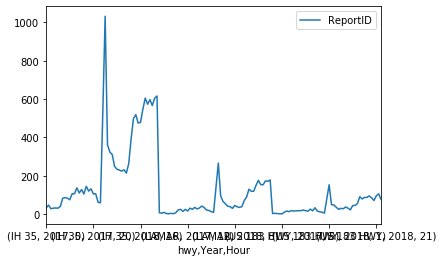

In [78]:
trafficplt = traffic_incident_ann.plot.line()
plt.show()